In [33]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import create_retrieval_chain
from langchain.schema.runnable import RunnableMap
from langchain.prompts import PromptTemplate
from llama_cpp import Llama

# Data Preprocessing

In [2]:
import pandas as pd
import os

# Step 1: Load Datasets
# Ensure the dataset files are in the same directory or provide paths
gen_sarc_path = "GEN-sarc-notsarc.csv"  # Replace with actual path
hyp_sarc_path = "HYP-sarc-notsarc.csv"  # Replace with actual path
rq_sarc_path = "RQ-sarc-notsarc.csv"  # Replace with actual path
news_path = "Sarcasm_Headlines_Dataset_v2.json"  # Replace with actual path
train_path = "train.csv"  # Replace with actual path
test_path = "test.csv"  # Replace with actual path

def load_csv_dataset(path, text_column, label_column, label_value=None):
    """Loads a CSV dataset and assigns sarcasm labels if needed."""
    if os.path.exists(path):
        df = pd.read_csv(path)
        if label_column:
            df = df[[text_column, label_column]]  # Keep text and label
        else:
            df = df[[text_column]]  # Keep only text
            df["label"] = label_value  # Assign sarcasm label if provided
        df.columns = ["text", "label"]  # Standardize column names
        return df
    else:
        print(f"File not found: {path}")
        return pd.DataFrame()

def load_json_dataset(path):
    """Loads a JSON dataset containing sarcastic and non-sarcastic headlines."""
    if os.path.exists(path):
        df = pd.read_json(path, lines=True)
        df = df[["headline", "is_sarcastic"]]
        df.columns = ["text", "label"]  # Standardize column names
        return df
    else:
        print(f"File not found: {path}")
        return pd.DataFrame()

# Load all datasets
df_gen_sarc = load_csv_dataset(gen_sarc_path, "text", None, 1)  # General sarcasm
df_hyp_sarc = load_csv_dataset(hyp_sarc_path, "text", None, 1)  # Hyperbolic sarcasm
df_rq_sarc = load_csv_dataset(rq_sarc_path, "text", None, 1)  # Rhetorical question sarcasm
df_news = load_json_dataset(news_path)  # News headlines dataset

# Load and rename train and test datasets
df_train = load_csv_dataset(train_path, "tweets", "class")  # Train dataset
df_test = load_csv_dataset(test_path, "tweets", "class")  # Test dataset

# Combine datasets
df_combined = pd.concat([
    df_gen_sarc, df_hyp_sarc, df_rq_sarc,
    df_news, df_train, df_test
], ignore_index=True)

# Step 2: Preprocessing
# Convert text to lowercase and remove NaN values
df_combined.dropna(inplace=True)
df_combined["text"] = df_combined["text"].str.lower()

# Display dataset summary
print("Dataset Loaded:")
print(df_combined.head())
print(f"Total samples: {len(df_combined)}")

# Save cleaned dataset
df_combined.to_csv("sarcasm_cleaned.csv", index=False)


Dataset Loaded:
                                                text label
0  if that's true, then freedom of speech is doom...     1
1  neener neener - is it time to go in from the p...     1
2  just like the plastic gun fear, the armour pie...     1
3  so geology is a religion because we weren't he...     1
4  well done monty. mark that up as your first ev...     1
Total samples: 127532


# Embedding

In [6]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 54.8 MB/s eta 0:00:00


In [34]:
# Step 2: Generate Embeddings
# Load preprocessed dataset
data_path = "sarcasm_cleaned.csv"
df_combined = pd.read_csv(data_path)

# Load a free embedding model
print("Generating text embeddings using Sentence Transformers...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convert text data into embeddings
documents = df_combined["text"].tolist()
embeddings = model.encode(documents, convert_to_tensor=False)

# Convert embeddings to a FAISS index
embeddings = np.array(embeddings, dtype='float32')
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)

# Save FAISS index
faiss.write_index(index, "sarcasm_db.index")
print("Embeddings stored in FAISS database.")

Generating text embeddings using Sentence Transformers...
Embeddings stored in FAISS database.


# Store and retrive data

In [10]:
pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00


In [35]:

# Step 3: Store & Retrieve Data
print("Setting up FAISS vector store for retrieval...")
retriever = FAISS.from_texts(
    texts=documents,
    embedding=HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
)
retriever = retriever.as_retriever()


retriever.vectorstore.save_local("sarcasm_retriever")

print("FAISS retriever stored successfully.")


Setting up FAISS vector store for retrieval...
FAISS retriever stored successfully.


In [16]:
!pip install -U langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.41
    Uninstalling langchain-core-0.3.41:
      Successfully uninstalled langchain-core-0.3.41


# Use RAG + GPT-4 for Sarcasm Classification

In [62]:
# Step 4: Use Local LLM for Sarcasm Classification
print("Initializing local Llama-2 model for sarcasm classification...")
llm_model_path = "mistral-7b.Q4_K.gguf"
llm = Llama(model_path=llm_model_path, n_ctx=2048)

def detect_sarcasm(input_text):
    """Detects sarcasm using a local Llama-2 model."""
    prompt = f"[INST] Is the following sentence sarcastic? {input_text} [/INST]"
    response = llm(prompt, max_tokens=50)

    if "choices" in response and len(response["choices"]) > 0:
        return response["choices"][0]["text"].strip()
    else:
        return "No response generated."


# Example usage
user_input = "Idli Dosa Sambhar Chutney Chutney, Kerla 100% Litracy saar."
result = detect_sarcasm(user_input)
print("Detection Result:", result)

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from mistral-7b.Q4_K.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.1
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_count

Initializing local Llama-2 model for sarcasm classification...


load_tensors:   CPU_Mapped model buffer size =  4165.37 MiB
llama_init_from_model: n_seq_max     = 1
llama_init_from_model: n_ctx         = 2048
llama_init_from_model: n_ctx_per_seq = 2048
llama_init_from_model: n_batch       = 512
llama_init_from_model: n_ubatch      = 512
llama_init_from_model: flash_attn    = 0
llama_init_from_model: freq_base     = 10000.0
llama_init_from_model: freq_scale    = 1
llama_init_from_model: n_ctx_per_seq (2048) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
llama_kv_cache_init: kv_size = 2048, offload = 1, type_k = 'f16', type_v = 'f16', n_layer = 32, can_shift = 1
llama_kv_cache_init: layer 0: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 1: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 2: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 3: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_cache_init: layer 4: n_embd_k_gqa = 1024, n_embd_v_gqa = 1024
llama_kv_c

Detection Result: It is difficult to determine if the sentence is sarcastic without more context. However, based on the information provided, it appears that the sentence is a play on words that combines two phrases with similar spellings but different meanings. "Id


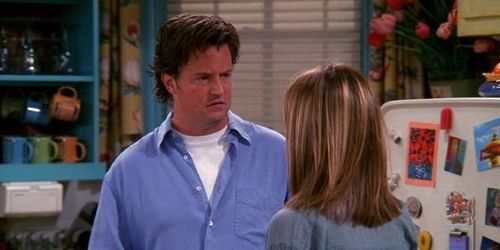

In [31]:
!pip install llama-cpp-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.7 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.7-cp311-cp311-linux_x86_64.whl size=4601138 sha256=4053bfb630a9acf69f901e704fc326f3939ad08e84eb3f37e84890fb33205399
  Stored in directory: /root/.cache/pip/wheels/eb/82/79/ac77fcd49324b75ae6aa18e63a87cf9da4371a57e2cdc8dc03
Successfully built llama-cpp-python


In [32]:
!wget -O mistral-7b.Q4_K.gguf https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.1-GGUF/resolve/main/mistral-7b-instruct-v0.1.Q4_K_M.gguf


--2025-03-11 08:29:51--  https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.1-GGUF/resolve/main/mistral-7b-instruct-v0.1.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 13.35.202.121, 13.35.202.40, 13.35.202.34, ...
Connecting to huggingface.co (huggingface.co)|13.35.202.121|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/46/12/46124cd8d4788fd8e0879883abfc473f247664b987955cc98a08658f7df6b826/14466f9d658bf4a79f96c3f3f22759707c291cac4e62fea625e80c7d32169991?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27mistral-7b-instruct-v0.1.Q4_K_M.gguf%3B+filename%3D%22mistral-7b-instruct-v0.1.Q4_K_M.gguf%22%3B&Expires=1741685391&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MTY4NTM5MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy80Ni8xMi80NjEyNGNkOGQ0Nzg4ZmQ4ZTA4Nzk4ODNhYmZjNDczZjI0NzY2NGI5ODc5NTVjYzk4YTA4NjU4ZjdkZjZiODI2LzE0NDY2ZjlkNjU4YmY0YTc5Zjk2YzNmM2YyMjc